# Portfolio Optimization using cvxpy

## Install cvxpy and other libraries

## Imports

`Pip install cvxpy`

In [20]:
import cvxpy as cvx
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Optimization with cvxpy

http://www.cvxpy.org/

Practice using cvxpy to solve a simple optimization problem. Find the optimal weights on a two-asset portfolio given the variance of Stock A, the variance of Stock B, and the correlation between Stocks A and B. Create a function that takes in these values as arguments and returns the vector of optimal weights, i.e., 

$\mathbf{x} = \begin{bmatrix}
x_A & x_B
\end{bmatrix}
$


Remember that the constraint in this problem is: $x_A + x_B = 1$



## Hints

### standard deviation
standard deviation $\sigma_A = \sqrt(\sigma^2_A)$, where $\sigma^2_A$ is variance of $x_A$
look at `np.sqrt()`

### covariance
correlation between the stocks is $\rho_{A,B}$

covariance between the stocks is $\sigma_{A,B} = \sigma_A \times \sigma_B \times \rho_{A,B}$

### x vector
create a vector of 2 x variables $\mathbf{x} = \begin{bmatrix}
x_A & x_B
\end{bmatrix}
$
we can use `cvx.Variable(2)`

### covariance matrix
The covariance matrix $P = 
\begin{bmatrix}
\sigma^2_A & \sigma_{A,B} \\ 
\sigma_{A,B} & \sigma^2_B 
\end{bmatrix}$

We can create a 2 x 2 matrix using a 2-dimensional numpy array
`np.array([["Cindy", "Liz"],["Eddy", "Brok"]])`

### quadratic form
We can write the portfolio variance $\sigma^2_p = \mathbf{x^T} \mathbf{P} \mathbf{x}$

Recall that the $\mathbf{x^T} \mathbf{P} \mathbf{x}$ is called the quadratic form.
We can use the cvxpy function `quad_form(x,P)` to get the quadratic form.

### objective function
Next, we want to define the objective function.  In this case, we want to minimize something.  What do we want to minimize in this case?  We want to minimize the portfolio variance, which is defined by our quadratic form $\mathbf{x^T} \mathbf{P} \mathbf{x}$

We can find the objective function using cvxpy `objective = cvx.Minimize()`.  Can you guess what to pass into this function?


### constraints
We can also define our constraints in a list.  For example, if you wanted the $\sum_{1}^{n}x = 1$, you could save a variable as `[sum(x)==1]`, where x was created using `cvx.Variable()`.

### optimization
So now that we have our objective function and constraints, we can solve for the values of $\mathbf{x}$.
cvxpy has the constructor `Problem(objective, constraints)`, which returns a `Problem` object.

The `Problem` object has a function solve(), which returns the minimum of the solution.  In this case, this is the minimum variance of the portfolio.

It also updates the vector $\mathbf{x}$.

We can check out the values of $x_A$ and $x_B$ that gave the minimum portfolio variance by using `x.value`

### Your work

Using the template below, extend to use three assests from yfinance. Your final notebook should be able to do the following:

1. Calculate the expected return for your portfolio.
2. Then optimize the portfolio allocation to reduce the portfolio risk


In [21]:
import cvxpy as cvx
import numpy as np

def optimize_twoasset_portfolio(varA, varB, rAB):
    """Create a function that takes in the variance of Stock A, the variance of
    Stock B, and the correlation between Stocks A and B as arguments and returns 
    the vector of optimal weights
    
    Parameters
    ----------
    varA : float
        The variance of Stock A.
        
    varB : float
        The variance of Stock B.    
        
    rAB : float
        The correlation between Stocks A and B.
        
    Returns
    -------
    x : np.ndarray
        A 2-element numpy ndarray containing the weights on Stocks A and B,
        [x_A, x_B], that minimize the portfolio variance.
    
    """
    # TODO: Use cvxpy to determine the weights on the assets in a 3-asset
    # portfolio that minimize portfolio variance.
    
    cov = np.sqrt(varA)*np.sqrt(varB)*rAB
    x = cvx.Variable(2)
    P = np.array([[varA, cov],[cov, varB]])
    objective = cvx.Minimize(cvx.quad_form(x,P))
    constraints = [sum(x)==1]
    problem = cvx.Problem(objective, constraints)
    min_value = problem.solve()    
    xA,xB = x.value   
    
    # return xA and xB    
    return xA, xB


In [22]:
"""Test run optimize_twoasset_portfolio()."""
xA,xB = optimize_twoasset_portfolio(0.1, 0.05, 0.25)
print("Weight on Stock A: {:.6f}".format(xA))
print("Weight on Stock B: {:.6f}".format(xB))

Weight on Stock A: 0.281935
Weight on Stock B: 0.718065


## My Work

#### Helper Functions

In [23]:
def portfolio_std(weight_map, logged_chgn_df):
    """
        Calculates the standard deviation of the entire portfolio for any number stocks in a portfolio.

        Parameters
        ----------
        weight_map: a dictionary that maps a stock symbol to it's weight in the portfolio.
        logged_chgn_df: dataframe that contains the logged daily change for each stock.
        Note: the keys(stock symbol) in the weight_map must be available in the logged_chgn_df in order to pull the stock data for calculation

        Returns
        -------
        Standard deviation of the whole portfolio.
    """
    all_weight = sum([x for x in weight_map.values()])
    if round(all_weight, 2) != 1:
        raise Exception('Weights does not sum to 1: ', all_weight)

    # aw**2 * a_std**2 + bw**2 * b_std**2 + cw**2 * c_std**2 + 2*aw*bw*a_std*b_std*ab + 2*aw*cw*a_std*c_std*ac + 2*bw*cw*b_std*c_std*bc
    # portfolio standard deviation can be broken into two parts
    # part 1: the normal components - weight^2 * std^2 for each asset
    # e.g. a_weight^2 * a_std^2
    normal_components = []
    for code, weight in weight_map.items():
        data = logged_chgn_df[code]
        std = data.std()
        normal_components.append(weight**2 * std**2)

    # part 2: correlation components - 2 * a_weight * b_weight * a_std * b_std * corr_a_b for each pair of assets
    # e.g. 2 * a_weight * b_weight * a_std * b_std * corr_a_b
    # note: correlation is between 2 assets, below logic will only calc correlation for a_c and not c_a
    corr_components = {}
    for key1 in weight_map:
        for key2 in weight_map:
            keys = [key1, key2]
            keys.sort()

            generated_key = f'{keys[0]}_{keys[1]}'
            if keys[0] != keys[1] and corr_components.get(generated_key) == None:
                w1, data1 = weight_map[keys[0]], logged_chgn_df[keys[0]]
                w2, data2 = weight_map[keys[1]], logged_chgn_df[keys[1]]
                std1 = data1.std()
                std2 = data2.std()
                corr = data1.corr(data2)
                corr_components[generated_key] = 2*w1*w2*std1*std2*corr

    # finally, we sum all the components together
    var = 0
    for nor_cmp in normal_components:
        var = var + nor_cmp

    for corr_cmp in corr_components.values():
        var = var + corr_cmp
    std = np.sqrt(var)
    return std

def optimize_three_asset_portfolio(varA, varB, varC, rAB, rAC, rBC):
    """
        Function that takes in the variance of Stock A, B and C 
        together with the correlation between each pair of stocks as arguments and returns 
        the vector of optimal weights.

        Parameters
        ----------
        varA : float - The variance of Stock A.
        varB : float - The variance of Stock B.    
        varC : float - The variance of Stock C.
        rAB  : float - The correlation between Stocks A and B.
        rAC  : float - The correlation between Stocks A and C.
        rBC  : float - The correlation between Stocks B and C.

        Returns
        -------
        x : np.ndarray
            A 3-elements numpy ndarray containing the weights on Stocks A, B and C,
            [x_A, x_B, x_C], that minimize the portfolio variance.
    """

    covAB = np.sqrt(varA)*np.sqrt(varB)*rAB
    covAC = np.sqrt(varA)*np.sqrt(varC)*rAC
    covBC = np.sqrt(varB)*np.sqrt(varC)*rBC
    x = cvx.Variable(3)
    P = np.array(
        [[varA, covAB, covAC], [covAB, varB, covBC], [covAC, covBC, varC]])
    objective = cvx.Minimize(cvx.quad_form(x, P))
    constraints = [sum(x) == 1]
    problem = cvx.Problem(objective, constraints)
    min_value = problem.solve()
    xA, xB, xC = x.value

    return xA, xB, xC


def optimize_portfolio_allocation(log_change_df, three_assets=('a', 'b', 'c')):
    """
        This is a wrapper function that takes logged daily changes in adj prices dataframe and three assets(string).
        It calculates the variances and correlations needed for 'optimize_three_asset_portfolio' and return the result from that function.

        Parameters
        ----------
        log_change_df: the dataframe that contains the logged daily changes in adj prices for each asset
        three_assets: a tuple that contains three asset codes. The raw data for these three asset codes must be in log_change_df

        Returns
        -------
        return value from optimize_three_asset_portfolio
    """
    asset_a, asset_b, asset_c = three_assets
    var_a = log_change_df[asset_a].var()
    var_b = log_change_df[asset_b].var()
    var_c = log_change_df[asset_c].var()
    corr_ab = log_change_df[asset_a].corr(log_change_df[asset_b])
    corr_ac = log_change_df[asset_a].corr(log_change_df[asset_c])
    corr_bc = log_change_df[asset_b].corr(log_change_df[asset_c])
    return optimize_three_asset_portfolio(var_a, var_b, var_c, corr_ab, corr_ac, corr_bc)


#### Get Average % Return for Estimation

In [24]:
# https://etfdb.com/etfs/
a1, a2, a3 = 'GLD', 'EUO', 'VOO'

invest_df = yf.download([a1, a2, a3],
                        start='2011-01-01',
                        end='2020-12-31',
                        progress=False)
                        
close_df = invest_df['Adj Close']
a1_price_change = (close_df[a1].iloc[-1] - close_df[a1].iloc[0]) / close_df[a1].iloc[0] / 10
a2_price_change = (close_df[a2].iloc[-1] - close_df[a2].iloc[0]) / close_df[a2].iloc[0] / 10
a3_price_change = (close_df[a3].iloc[-1] - close_df[a3].iloc[0]) / close_df[a3].iloc[0] / 10

return_map = {a1: round(a1_price_change, 6), a2: round(a2_price_change, 6), a3: round(a3_price_change, 6)}
print(f'Get the average percentage price change for the past few years {return_map}')


Get the average percentage price change for the past few years {'GLD': 0.0281, 'EUO': 0.009552, 'VOO': 0.261074}


#### Get Data & Log Changes For Prices
1. Plot the normalized prices to observe general trend and correlation between assets
2. Log the daily close price change 
3. Display the correlation matrix

                 EUO       GLD       VOO
Date                                    
2020-11-17 -0.001673 -0.003676 -0.004997
2020-11-18  0.002091 -0.005739 -0.012207
2020-11-19 -0.004605 -0.001882  0.004177
2020-11-20  0.003770  0.003021 -0.006716
2020-11-23  0.001671 -0.019890  0.005894


EUO       GLD       VOO
EUO  1.000000 -0.476731 -0.275448
GLD -0.476731  1.000000  0.182386
VOO -0.275448  0.182386  1.000000

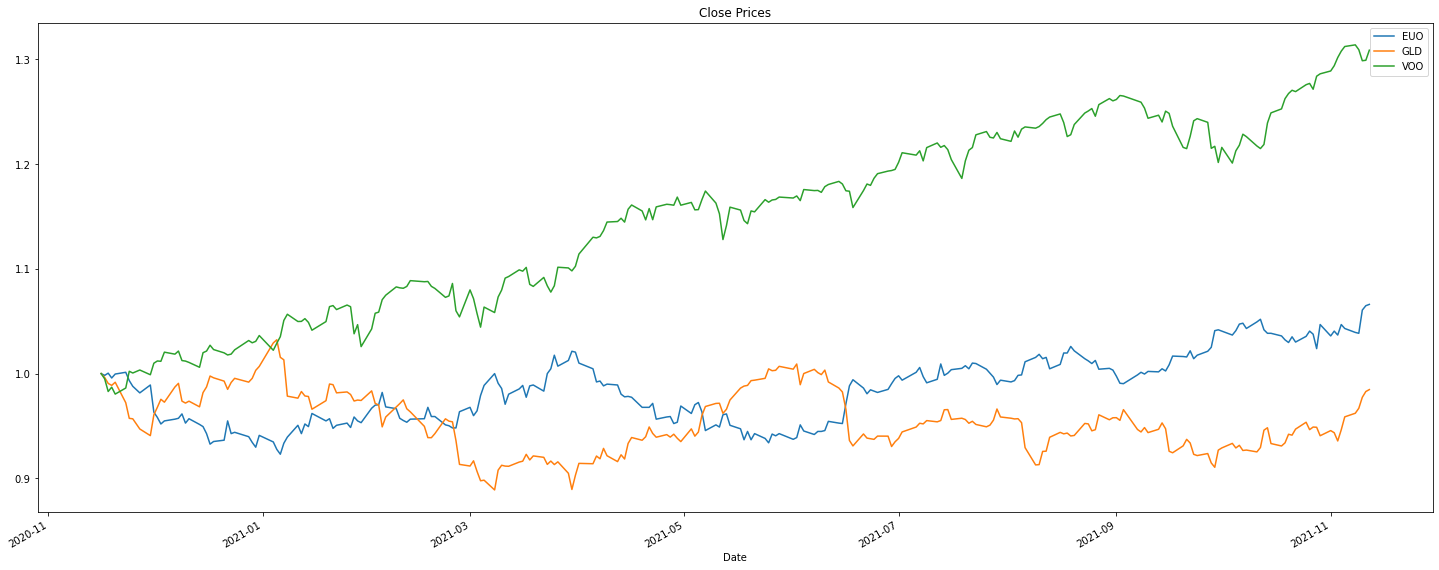

In [25]:
invest_df = yf.download([a1, a2, a3],
                        start='2020-11-16',
                        end='2021-11-15',
                        progress=False)

close_df = invest_df['Adj Close']
norm_df = close_df/close_df.iloc[0, :]
norm_df.plot(title="Close Prices", figsize=(25, 10))
log_change_df = close_df.pct_change().apply(lambda x: np.log(1+x)).dropna()

log_change_df.corr()


#### Plot Correlation Matrix Heatmap

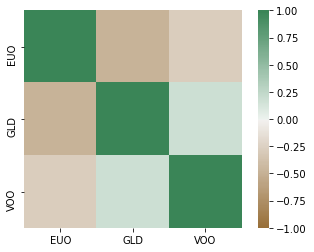

In [26]:
axis_corr = sns.heatmap(
    log_change_df.corr(),
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(50, 500, n=500),
    square=True
)

plt.show()


#### Optimize Portfolio Allocation

In [27]:
print('-Buying Individual Stock will have below standard deviation & return')
print(f"{a1} Return : {round(return_map[a1]*100, 2)}% | Standard Deviation : {round(log_change_df[a1].std(), 4)}")
print(f"{a2} Return : {round(return_map[a2]*100, 2)}% | Standard Deviation : {round(log_change_df[a2].std(), 4)}")
print(f"{a3} Return : {round(return_map[a3]*100, 2)}% | Standard Deviation : {round(log_change_df[a3].std(), 4)}")

w_agg, w_comt, w_vxx = optimize_portfolio_allocation(log_change_df, (a1, a2, a3))
weight_map = {a1: round(w_agg, 4), a2: round(w_comt, 4), a3: round(w_vxx, 4)}
port_std = portfolio_std(weight_map, log_change_df)
portfolio_return = return_map[a1] * w_agg + return_map[a2] * w_comt + return_map[a3] * w_vxx
print('')
print('-Buying the 3 asset portfolio will have below standard deviation & return')
print(f"Optimized Weight Allocation {weight_map}")
print(f'Portfolio Return : {round(portfolio_return*100, 2)}% | Standard Deviation : {round(port_std, 4)}')


-Buying Individual Stock will have below standard deviation & return
GLD Return : 2.81% | Standard Deviation : 0.0089
EUO Return : 0.96% | Standard Deviation : 0.0075
VOO Return : 26.11% | Standard Deviation : 0.0076

-Buying the 3 asset portfolio will have below standard deviation & return
Optimized Weight Allocation {'GLD': 0.2869, 'EUO': 0.4482, 'VOO': 0.2649}
Portfolio Return : 8.15% | Standard Deviation : 0.0034


<br>
<br>
<br>

### Own Implementation of Portfolio Optimization - Optional
I implemented this before e-tivity 5 notebook becomes available. In e-tivity 4, we are asked to optimize portfolio for a 3 asset portfolio.<br>
Below is a brute force way of optimizing the assets weights.<br>
It iterates the allocation from ...<br>
1. asset A: 0, asset B: 0, asset C: 100%
2. asset A: 0, asset B: 1%, asset C: 99%
3. asset A: 0, asset B: 2%, asset C: 98%
...
4. asset A: 100%, asset B: 0, asset C: 0

For each interation, it gets the portfolio standard deviation. At the same time, the lowest standard deviation and weight allocation is stored.<br>
The weight allocation stored will be the optimal asset allocation.<br>
This algorithm is iterative and very slow(7.6s on my local pc) compared against cvx. Result, however, is very close to the result from cvx.

In [28]:
print('-Buying Individual Stock will have below standard deviation & return')
print(f"{a1} Return : {round(return_map[a1]*100, 2)}% | Standard Deviation : {round(log_change_df[a1].std(), 4)}")
print(f"{a2} Return : {round(return_map[a2]*100, 2)}% | Standard Deviation : {round(log_change_df[a2].std(), 4)}")
print(f"{a3} Return : {round(return_map[a3]*100, 2)}% | Standard Deviation : {round(log_change_df[a3].std(), 4)}")

port_std, chosen_weight = None, None
for x in range(101):
    for y in range(101 - x):
        weight_map = {a1: x / 100, a2: y / 100, a3: (100 - y - x) / 100}
        std = portfolio_std(weight_map, log_change_df)
        if port_std == None or std < port_std:
            port_std = std
            chosen_weight = weight_map

portfolio_return = return_map[a1] * chosen_weight[a1] + return_map[a2] * chosen_weight[a2] + return_map[a3] * chosen_weight[a3]
print('')
print('-Buying the 3 asset portfolio will have below standard deviation & return')
print(f'Optimized Weight Allocation {chosen_weight}')
print(f'Portfolio Return : {round(portfolio_return*100, 2)}% | Standard Deviation : {round(port_std, 4)}')


-Buying Individual Stock will have below standard deviation & return
GLD Return : 2.81% | Standard Deviation : 0.0089
EUO Return : 0.96% | Standard Deviation : 0.0075
VOO Return : 26.11% | Standard Deviation : 0.0076

-Buying the 3 asset portfolio will have below standard deviation & return
Optimized Weight Allocation {'GLD': 0.29, 'EUO': 0.45, 'VOO': 0.26}
Portfolio Return : 8.03% | Standard Deviation : 0.0034
